In [ ]:
!nvidia-smi

Wed Dec 13 12:46:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install --upgrade gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4479697c2a268fa6a47f3d06256822d50ca0b3450390f4b848e9d182a870ce9c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4ef769dff1205264eaf9867271f1c1d24235ed9d39d96b90dde4363f488f5b0c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-

In [ ]:
!pip install timm

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

In [ ]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 1999639040/1999639040 [00:52<00:00, 37895717.48it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


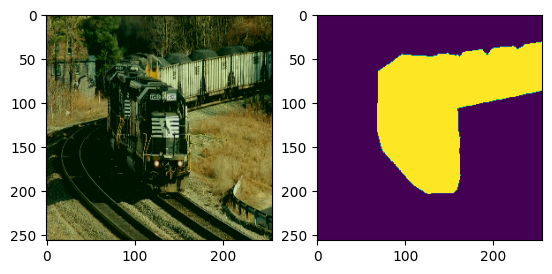

In [ ]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [ ]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class ResUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet50", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(2048, 1024)
        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        #x1 (B, 64, 128, 128) size/2
        #x2 (B, 256, 64, 64) size/4
        #x3 (B, 512, 32, 32) size/16
        #x4 (B, 1024, 16, 16) size/32
        #x5 (B, 2048, 8, 8) size/64
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = ResUnet(21).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "modelUNet_ep_{}.pth".format(ep))

torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')

100%|██████████| 92/92 [04:30<00:00,  2.95s/it]


EP 1, train loss = 1.23458750814688, accuracy = 0.7489601302016629, IoU = 0.05325225813955557, dice = 0.060800597030934087


100%|██████████| 92/92 [04:34<00:00,  2.98s/it]


EP 2, train loss = 1.0342967699134284, accuracy = 0.7502215234308295, IoU = 0.057327493821662634, dice = 0.0663260392478255


100%|██████████| 92/92 [04:30<00:00,  2.94s/it]


EP 3, train loss = 0.9706046464013272, accuracy = 0.7618068528305637, IoU = 0.07119570530014611, dice = 0.08478956645140882


100%|██████████| 92/92 [04:26<00:00,  2.90s/it]


EP 4, train loss = 0.903848448737723, accuracy = 0.7680571926096098, IoU = 0.07805506600056841, dice = 0.09392161655132888


100%|██████████| 92/92 [04:19<00:00,  2.83s/it]


EP 5, train loss = 0.8384207018086167, accuracy = 0.7769367968449827, IoU = 0.09141381056419487, dice = 0.11093651181687422


100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


EP 6, train loss = 0.7660699623530028, accuracy = 0.792572688535263, IoU = 0.11860477093790399, dice = 0.14513982197300332


100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


EP 7, train loss = 0.6887152953877476, accuracy = 0.804977125157424, IoU = 0.1330600805947038, dice = 0.16192772153948173


100%|██████████| 92/92 [04:22<00:00,  2.85s/it]


EP 8, train loss = 0.6177145815937897, accuracy = 0.8105435501682302, IoU = 0.14563963159185941, dice = 0.17967536752341223


100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


EP 9, train loss = 0.5635455791416064, accuracy = 0.8256576100333792, IoU = 0.17796602210060494, dice = 0.22418128678707477


100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


EP 10, train loss = 0.48963363835069, accuracy = 0.8448234829094892, IoU = 0.23336416898203677, dice = 0.2891961080454738


100%|██████████| 92/92 [04:26<00:00,  2.90s/it]


EP 11, train loss = 0.45285811059461917, accuracy = 0.8553754254117039, IoU = 0.25809305124595516, dice = 0.318885968356836


100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


EP 12, train loss = 0.3977210521697998, accuracy = 0.8783454269659324, IoU = 0.3081026053656646, dice = 0.37245884358557196


100%|██████████| 92/92 [04:18<00:00,  2.80s/it]


EP 13, train loss = 0.36014267557957136, accuracy = 0.8886685189002198, IoU = 0.35620295920007217, dice = 0.4255065168839335


100%|██████████| 92/92 [04:23<00:00,  2.86s/it]


EP 14, train loss = 0.3244910420127254, accuracy = 0.9000226005178983, IoU = 0.39178213558561814, dice = 0.46175900769363987


100%|██████████| 92/92 [04:21<00:00,  2.84s/it]


EP 15, train loss = 0.3021591225934159, accuracy = 0.9048352892932996, IoU = 0.4124883270003105, dice = 0.4832907195299701


100%|██████████| 92/92 [04:21<00:00,  2.85s/it]


EP 16, train loss = 0.2753408346019807, accuracy = 0.9131199154046064, IoU = 0.44037581450952207, dice = 0.5116727475911542


100%|██████████| 92/92 [04:22<00:00,  2.86s/it]


EP 17, train loss = 0.2657512362863197, accuracy = 0.9150155176881885, IoU = 0.45210439634453403, dice = 0.5253441667621904


100%|██████████| 92/92 [04:29<00:00,  2.93s/it]


EP 18, train loss = 0.2624105653150485, accuracy = 0.9166415063409857, IoU = 0.45637829903044985, dice = 0.5280945167515447


100%|██████████| 92/92 [04:26<00:00,  2.89s/it]


EP 19, train loss = 0.24162406934415057, accuracy = 0.9221384955234215, IoU = 0.4792562754102092, dice = 0.5507021504021733


100%|██████████| 92/92 [04:25<00:00,  2.88s/it]


EP 20, train loss = 0.23430275851911533, accuracy = 0.9253483652417126, IoU = 0.49094535418546914, dice = 0.562146389582118


100%|██████████| 92/92 [04:22<00:00,  2.86s/it]


EP 21, train loss = 0.21244929690178627, accuracy = 0.9304479067442847, IoU = 0.5223492831806016, dice = 0.5961181684269932


100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


EP 22, train loss = 0.20980462350480544, accuracy = 0.9322041996189805, IoU = 0.5205255590501379, dice = 0.59344800899589


100%|██████████| 92/92 [04:20<00:00,  2.83s/it]


EP 23, train loss = 0.19945504642575165, accuracy = 0.9354013328343793, IoU = 0.5405880297468009, dice = 0.6134927398194381


100%|██████████| 92/92 [04:21<00:00,  2.85s/it]


EP 24, train loss = 0.1959381355125396, accuracy = 0.9352914049325745, IoU = 0.534639830146331, dice = 0.6061798910625645


100%|██████████| 92/92 [04:33<00:00,  2.98s/it]


EP 25, train loss = 0.18305155121889272, accuracy = 0.9391103233796, IoU = 0.5576497646954541, dice = 0.6314363036650777


100%|██████████| 92/92 [04:30<00:00,  2.94s/it]


EP 26, train loss = 0.1784548976870834, accuracy = 0.9399179865102298, IoU = 0.5619909848020377, dice = 0.6353372289834778


100%|██████████| 92/92 [04:26<00:00,  2.89s/it]


EP 27, train loss = 0.17176778524951206, accuracy = 0.9423159719164905, IoU = 0.5601240243416666, dice = 0.6316214523028806


100%|██████████| 92/92 [04:32<00:00,  2.97s/it]


EP 28, train loss = 0.16015689563555796, accuracy = 0.945600363726173, IoU = 0.5898444017425912, dice = 0.6616435070506862


100%|██████████| 92/92 [04:31<00:00,  2.96s/it]


EP 29, train loss = 0.1626312219705738, accuracy = 0.9457244143459966, IoU = 0.5929535650164703, dice = 0.6652462313084003


100%|██████████| 92/92 [04:28<00:00,  2.92s/it]


EP 30, train loss = 0.16814628748294433, accuracy = 0.9435389367609076, IoU = 0.581073275355042, dice = 0.6534856310307654


In [ ]:
model28 = ResUnet(21).to(device)

In [ ]:
model28.load_state_dict(torch.load('/content/modelUNet_ep_28.pth'))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
for ep in range(1, 1+2):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "modelUNet_ep_{}.pth".format(ep))

torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')

100%|██████████| 92/92 [04:55<00:00,  3.21s/it]


EP 1, train loss = 0.14337948225235028, accuracy = 0.9508895561343333, IoU = 0.6355837199205909, dice = 0.7086411460501248


100%|██████████| 92/92 [04:46<00:00,  3.11s/it]


EP 2, train loss = 0.13634162497976438, accuracy = 0.9528030437198493, IoU = 0.6484596559910175, dice = 0.7199064955685308


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)

In [ ]:
model28.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))

<All keys matched successfully>

In [ ]:
for ep in range(1, 1+3):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model28.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model28(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "modelUNet_ep_{}.pth".format(ep))

torch.save(model.state_dict(), '/content/drive/MyDrive/model285.pth')

100%|██████████| 92/92 [04:45<00:00,  3.10s/it]


EP 1, train loss = 0.14211217692640962, accuracy = 0.9514414469401041, IoU = 0.6324487471841073, dice = 0.7035898308936364


100%|██████████| 92/92 [04:39<00:00,  3.03s/it]


EP 2, train loss = 0.14136801831057813, accuracy = 0.9514850658145758, IoU = 0.6265952938892803, dice = 0.6973786494119572


100%|██████████| 92/92 [04:42<00:00,  3.07s/it]


EP 3, train loss = 0.14283954435603216, accuracy = 0.9507695599331882, IoU = 0.6236121068235303, dice = 0.6956576278300884


In [ ]:
torch.save(model28.state_dict(), '/content/drive/MyDrive/model285.pth')

background
car
motorbike
person


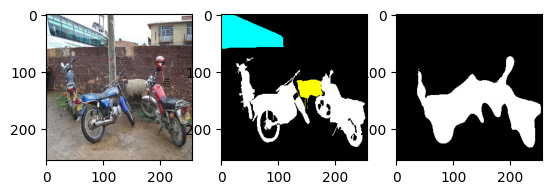

In [ ]:
import random
id = random.randint(0, test_dataset.__len__())
with torch.no_grad():
    model28.eval()
    x, y = test_dataset.__getitem__(id)
    y_predict = model28(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
    for i in np.unique(y_predict).tolist():
        print(VOC_CLASSES[i])
    color_mask_predict = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()

In [ ]:
!cp /content/modelUNet_ep_28.pth /content/drive/MyDrive/modelUNet_ep_28.pth